# Single-step model
We run all the examples in Jupyter notebook.
We start by importing usefull modules and checking if we have the correct versions installed.

In [1]:
import tensorflow as tf
from keras import optimizers

import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd


# min-maxScaler
from sklearn.preprocessing import MinMaxScaler

# plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import sqrt

Using TensorFlow backend.


# Here we import the data, the first comments is an example of how we import the data on mac the second on windows.

In [2]:
# "/Users/vasileioskilis/Desktop/projectA1988/dataset/GOOGL5yearsd.csv"
# "C:\\Users\\KILDE\\Desktop\\vxk969\\dataset\\AAPL_.csv"
stock=pd.read_csv("C:\\Users\\KILDE\\Desktop\\vxk969\\dataset\\AAPL_.csv")
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-06-09,26.398571,26.420000,25.107143,25.944286,22.459904,472098200
1,2008-06-10,25.787144,26.682858,25.574286,26.520000,22.958296,285235300
2,2008-06-11,26.334286,26.571428,25.655714,25.830000,22.360960,240387700
3,2008-06-12,25.927143,26.085714,24.457144,24.751429,21.427246,327083400
4,2008-06-13,24.520000,24.879999,23.615715,24.624287,21.317177,336489300


# Here we check for null values, the types of the data, histogram

In [3]:
stock.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2031 non-null   object 
 1   Open       2031 non-null   float64
 2   High       2031 non-null   float64
 3   Low        2031 non-null   float64
 4   Close      2031 non-null   float64
 5   Adj Close  2031 non-null   float64
 6   Volume     2031 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 111.2+ KB


In [5]:
 stock["Date"].value_counts()

2012-03-30    1
2010-10-15    1
2013-11-14    1
2013-03-01    1
2010-06-09    1
             ..
2012-02-15    1
2011-04-21    1
2011-09-21    1
2010-06-02    1
2011-04-04    1
Name: Date, Length: 2031, dtype: int64

In [6]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2031.000000,2031.000000,2031.000000,2031.000000,2031.000000,2.031000e+03
mean,66.012763,66.640247,65.306271,65.981170,59.043462,1.166828e+08
std,33.868839,34.121268,33.576296,33.843356,31.556020,7.934929e+07
min,11.341429,11.714286,11.171429,11.171429,9.671075,1.304640e+07
25%,36.172857,36.612856,35.585714,36.077858,31.232503,6.193420e+07
50%,64.472855,65.134285,63.627144,64.302856,56.453358,9.826880e+07
75%,94.365002,95.355000,93.444999,94.385002,85.107551,1.487752e+08
max,134.460007,134.539993,131.399994,133.000000,122.150032,6.555143e+08


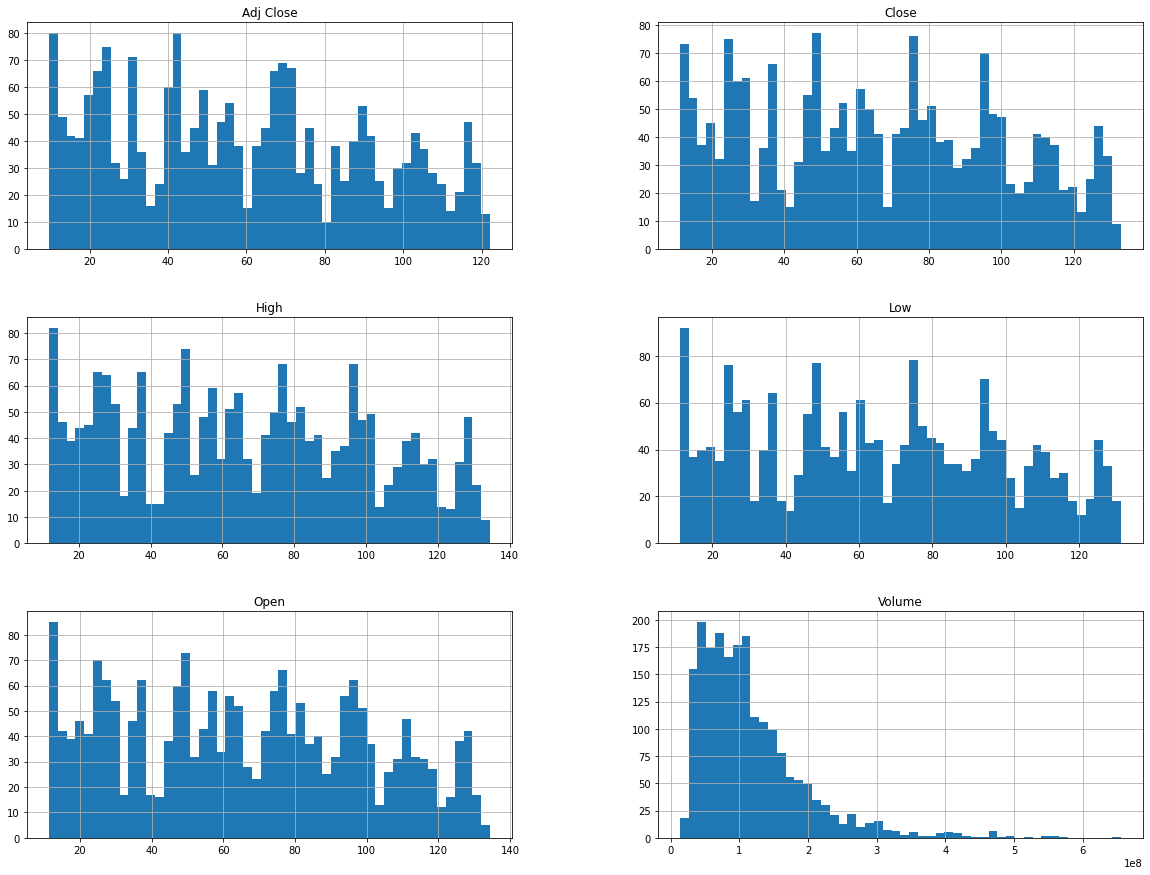

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
stock.hist(bins=50, figsize=(20,15))
plt.show()

# We create a panada series, with Date as an index to the closing price and plot it

In [8]:
close_price = stock['Close']
close_price.index = stock['Date']
close_price.head()

Date
2008-06-09    25.944286
2008-06-10    26.520000
2008-06-11    25.830000
2008-06-12    24.751429
2008-06-13    24.624287
Name: Close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000215A434C288>],
      dtype=object)

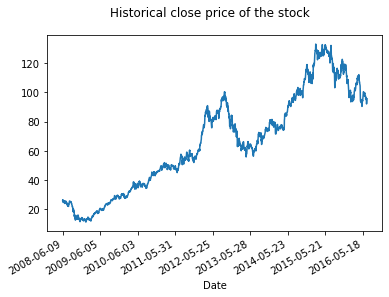

In [9]:
close_price.plot(subplots=True, title='Historical close price of the stock')

# Reshape close price and scale the data

In [10]:
close_price = stock.Close.values

In [11]:
close_price = np.reshape(close_price,(-1,1))

In [12]:
scaler = MinMaxScaler()
data_normalised = scaler.fit_transform(close_price)

# We split the dataset into 80% train, 10% validation and 10% test

In [13]:
train_size = int(len(data_normalised) * 0.80)
half_rest = int((len(data_normalised) - train_size)/2)

train_set = data_normalised[0:train_size,:]
val_set = data_normalised[train_size:train_size+half_rest,:]
test_set = data_normalised[train_size+half_rest:len(data_normalised),:]

# Method that creates sliding windows

In [14]:
def createWindows(dataset, window):
    X_train = []
    Y_train = []
    
    for i in range(len(dataset)-window-1):
        X_train.append(dataset[i:(i+window),0])
        Y_train.append(dataset[i+window,0])
    return np.array(X_train),np.array(Y_train)

# Create the windows and reshape the data so we can feed them to the LSTM

Input shape for an lstm (batch_size, time_steps, seq_len), window size 20 ,single step prediction the last element of the window is the target

In [15]:
X_train, Y_train = createWindows(train_set,20)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [16]:
X_val, Y_val = createWindows(val_set,20)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [17]:
X_test, Y_test = createWindows(test_set,20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# We combine the X_train and Y_train to tensors and shuffle them, also we choose the batch size

In [18]:
BATCH_SIZE = 60
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# Exponential learning rate 
 We used that only for the experiments when we were tring to find the best model.

In [19]:
# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

In [20]:
# def exponential_decay_fn(epoch):
# return 0.01 * 0.1**(epoch / 20)

In [21]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Here we were changing the learning's rate value for the experiments

In [22]:
 opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Model
This is the best model we found

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=True, input_shape= X_train.shape[-2:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(1)
    ])

# simple_lstm_model.compile(tf.keras.optimizers.Adam(learning_rate=0.003),loss="mse" )
model.compile(loss="mse", optimizer=opt)

Here we were just checking that the learning rate has the correct value

In [24]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.001


# Summary of the model and a tree scrature of the model

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 200)            176800    
_________________________________________________________________
dropout (Dropout)            (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 497,801
Trainable params: 497,801
Non-trainable params: 0
__________________________________________________

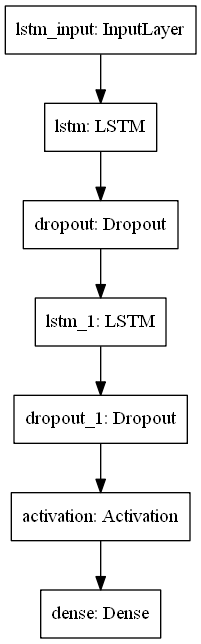

In [26]:
tf.keras.utils.plot_model(model)

# Train the model

In [27]:
lstm = model.fit(train_univariate, epochs=15,steps_per_epoch=200,validation_data=val_univariate,validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/15
200/200 [==============================] - 7s 35ms/step - loss: 0.0243 - val_loss: 0.0016
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 9.2865e-04 - val_loss: 0.0045
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 8.2369e-04 - val_loss: 0.0029
Epoch 4/15
200/200 [==============================] - 2s 8ms/step - loss: 6.7792e-04 - val_loss: 0.0047
Epoch 5/15
200/200 [==============================] - 2s 8ms/step - loss: 5.5074e-04 - val_loss: 0.0040
Epoch 6/15
200/200 [==============================] - 2s 8ms/step - loss: 4.9589e-04 - val_loss: 0.0027
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 4.4899e-04 - val_loss: 0.0023
Epoch 8/15
200/200 [==============================] - 2s 8ms/step - loss: 4.0035e-04 - val_loss: 0.0025
Epoch 9/15
200/200 [==============================] - 2s 8ms/step - loss: 3.9844e-04 - val_loss: 0.0026
Epoch 10/15
200/200 [===

In [28]:
lstm.params

{'batch_size': None,
 'epochs': 15,
 'steps': 200,
 'samples': 200,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

In [29]:
# model.save("my_model")

# Method we used to print the windows

In [30]:
def plot(timeseries, real, prediction):
    plt.plot(timeseries.flatten(), ".-")
    time_steps = timeseries[0].shape[0]
    if real is not None:
        plt.plot(time_steps, real,"bx", markersize=10)
    if prediction is not None:
        plt.plot (time_steps, prediction,'go')
    return plt

# Model evaluate on validation set

In [31]:
y_true_val= Y_val
y_true_val= scaler.inverse_transform(y_true_val.reshape(-1, 1)).reshape(-1 ,)

In [32]:
y_pred_val = model.predict(X_val).reshape(-1, )
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1)).reshape(-1 ,)

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_val, y_pred_val)

3.5098215318724235

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_val, y_pred_val)

15.649325542496506

In [35]:
# root mean square error
rms = sqrt(mean_squared_error(y_true_val, y_pred_val))
rms

3.9559228433447116

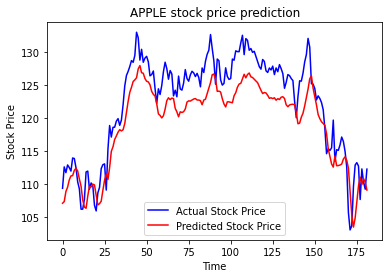

In [36]:
plt.plot(y_true_val, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_val, color = 'red', label = 'Predicted Stock Price')
plt.title('APPLE stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot some example windows
These are only some of the windows we ploted as an example

<module 'matplotlib.pyplot' from 'C:\\Users\\KILDE\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

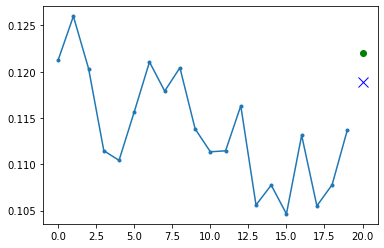

In [37]:
plot(X_train[0],Y_train[0],model.predict(X_train)[0])

<module 'matplotlib.pyplot' from 'C:\\Users\\KILDE\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

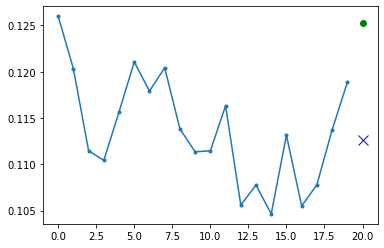

In [38]:
plot(X_train[1],Y_train[1],model.predict(X_train)[1])

<module 'matplotlib.pyplot' from 'C:\\Users\\KILDE\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

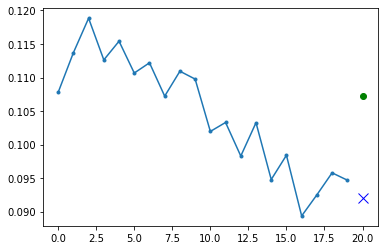

In [39]:
plot(X_train[18],Y_train[18],model.predict(X_train)[18])

# Evaluation on test set

In [40]:
y_true_test = Y_test
y_true_test = scaler.inverse_transform(Y_test.reshape(-1, 1)).reshape(-1 ,)

In [41]:
y_pred_test = model.predict(X_test).reshape(-1, )
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).reshape(-1 ,)

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_test, y_pred_test)

1.6581815138613172

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_test, y_pred_test)

4.5283824433916315

In [44]:
# root mean square error
rms = sqrt(mean_squared_error(y_true_test, y_pred_test))
rms

2.127999634255521

In [45]:
bill= np.mean((np.absolute(y_true_test-y_pred_test)/y_true_test)*100)
bill

1.5848492102282872

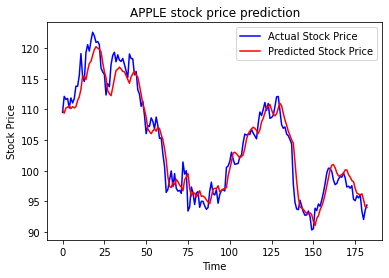

In [46]:
plt.plot(y_true_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_test, color = 'red', label = 'Predicted Stock Price')
plt.title('APPLE stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# websites used to create this program

https://www.tensorflow.org/tutorials/structured_data/time_series